# DL-CBIR using ViT Base-16 Architecture

**Online Phase**
***

# Libraries

In [ ]:
import os
import logging
from PIL import Image

import ast
import cv2
import numpy as np
import pandas as pd

import timm
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor

import joblib
from joblib import load
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Extras
import time
from google.colab import drive
import matplotlib.pyplot as plt
from google.colab import userdata

In [ ]:
# HuggingFace Token
os.environ['HF_TOKEN'] = userdata.get('HF_TOKEN')

In [ ]:
# Reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Detect Device

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


# Configuration Parameters

In [ ]:
DIR_PATH = '/content/drive/MyDrive/ML_Datasets/corel_1k_dataset/'
FEATURES_PATH = '/content/drive/MyDrive/ML_Datasets/vit_b_16_feature_vectors.csv'
MODELS_PATH = '/content/drive/MyDrive/ML_Models/'
svm_model_path = MODELS_PATH + 'vit_b_16_svm_model.joblib'

TRAIN_SPLIT = 0.8
BATCH_SIZE = 32

N_WORKERS = 2

PCA_DIM = 64
N_RESULTS = 10

# Logging Setup

In [ ]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Remove any existing handlers
if logger.hasHandlers():
    logger.handlers.clear()

# Add a new stream handler
stream_handler = logging.StreamHandler()
stream_handler.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)

# Connecting to the dataset

In [ ]:
drive.mount('/content/drive')
print(f"Available classes: {os.listdir(DIR_PATH + '/training_set')}")
print(f"Number of classes: {len(os.listdir(DIR_PATH + '/training_set'))}")

Mounted at /content/drive
Available classes: ['flowers', 'bus', 'foods', 'monuments', 'dinosaurs', 'peolpe_and_villages_in_Africa', 'elephants', 'horses', 'beaches', 'mountains_and_snow']
Number of classes: 10


# Components

## Data Loader

In [ ]:
def get_data_transforms():
    return transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

def load_images_and_labels(data_dir, target_class=None):
    """
    Loads images (optionally only from a specific class) and returns:
      - features (torch.Tensor) of shape (N, C, H, W) on DEVICE
      - labels   (torch.Tensor) of shape (N,) on DEVICE
      - file_names (list) of file paths for each image

    Args:
        data_dir (str): Directory path containing class subdirectories.
        target_class (str or list[str], optional): Only load images from this class (or list of classes).
                                                   If None, loads all classes.
    """
    if not os.path.exists(data_dir):
        raise FileNotFoundError(f"Data directory {data_dir} not found.")

    transform_pipeline = get_data_transforms()
    dataset = datasets.ImageFolder(root=data_dir)  # no transform yet

    # Determine which class indices to keep
    if target_class is None:
        valid_class_idxs = set(dataset.class_to_idx.values())
    else:
        if isinstance(target_class, str):
            target_list = [target_class]
        else:
            target_list = list(target_class)
        valid_class_idxs = {dataset.class_to_idx[c] for c in target_list}

    # Filter samples
    filtered_samples = [
        (path, label)
        for (path, label) in dataset.samples
        if label in valid_class_idxs
    ]

    feature_list = []
    label_list = []
    file_names  = []

    for img_path, label in filtered_samples:
        img = Image.open(img_path).convert('RGB')
        img_t = transform_pipeline(img)
        feature_list.append(img_t)
        label_list.append(label)
        file_names.append(img_path)

    # Stack and move to DEVICE
    features = torch.stack(feature_list).to(DEVICE)      # (N, C, H, W)
    labels   = torch.tensor(label_list, device=DEVICE)   # (N,)

    return features, labels, file_names

## Pre-trained ViT Base-16 Model for Feature Extraction

In [ ]:
class ViTFeatureExtractor(nn.Module):
    def __init__(self):
        super(ViTFeatureExtractor, self).__init__()
        # Load pre‑trained ViT and remove its classification head
        self.model = timm.create_model('vit_base_patch16_224', pretrained=True)
        self.model.head = nn.Identity()
        # Move to DEVICE and set to eval mode
        self.model.to(DEVICE)
        self.model.eval()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Extracts ViT features for a batch of images.

        Args:
            x (torch.Tensor): Batch of images as a tensor of shape (N, C, H, W),
                              already resized/cropped/normalized to 224×224.

        Returns:
            torch.Tensor: Feature tensor of shape (N, embed_dim) on DEVICE.
        """
        # Ensure input is on DEVICE
        x = x.to(DEVICE)
        with torch.no_grad():
            features = self.model(x)
        return features

## PCA for Feature Extraction

In [ ]:
def compute_normalized_pca(features: torch.Tensor, reduced_dim: int) -> torch.Tensor:
    """
    Performs PCA-based dimensionality reduction on a tensor of AlexNet features (N, 4096)
    followed by L2 normalization. The output always has shape (N, reduced_di'flowers'm), even if the
    number of available principal components (i.e. batch size N) is less than reduced_dim.
    In such cases, the projection matrix is padded with zeros. All computation happens on DEVICE.

    Args:
        features (torch.Tensor): Input tensor of shape (N, 4096), where N is the number of images.
        reduced_dim (int): Target dimensionality after PCA.

    Returns:
        torch.Tensor: L2‑normalized reduced features of shape (N, reduced_dim), on DEVICE.
    """
    # Move features to DEVICE
    features = features.to(DEVICE)

    # Step 1: Center the data
    mean = features.mean(dim=0, keepdim=True)               # (1, 4096)
    features_centered = features - mean                     # (N, 4096)

    # Step 2: Compute SVD on the centered data
    U, S, Vh = torch.linalg.svd(features_centered, full_matrices=False)
    # Vh has shape (min(N, 4096), 4096)
    num_components = Vh.shape[0]

    # Step 3: Select top principal components and form projection matrix
    if num_components >= reduced_dim:
        # Enough components
        principal_components = Vh[:reduced_dim].T          # (4096, reduced_dim)
    else:
        # Pad with zeros
        principal_components = Vh[:num_components].T       # (4096, num_components)
        pad_width = reduced_dim - num_components
        padding = torch.zeros((features.shape[1], pad_width), device=DEVICE)
        principal_components = torch.cat([principal_components, padding], dim=1)  # (4096, reduced_dim)

    # Step 4: Project onto the reduced subspace
    reduced_features = features_centered @ principal_components  # (N, reduced_dim)

    # Step 5: L2‑normalize each row
    reduced_features_normalized = F.normalize(reduced_features, p=2, dim=1)  # (N, reduced_dim)

    return reduced_features_normalized


## DCT for Feature Extraction

In [ ]:
def compute_normalized_dct(images: torch.Tensor) -> torch.Tensor:
    """
    Computes the L2‑normalized DCT feature vector for each image in a batch,
    returning a tensor on DEVICE.

    Args:
        images (torch.Tensor): Batch of input images with shape (N, C, H, W),
                               where N is the number of images and C is the number of channels (3).

    Returns:
        torch.Tensor: Tensor of L2‑normalized DCT feature vectors with shape (N, feature_length),
                      on DEVICE.
    """
    # Move to CPU and convert to HWC numpy array
    images_np = images.permute(0, 2, 3, 1).cpu().numpy()  # shape: (N, H, W, C)

    dct_features = []
    for img in images_np:
        # Grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # float32
        gray_f = np.float32(gray)
        # DCT
        dct_res = cv2.dct(gray_f)
        # Flatten
        vec = dct_res.flatten()
        # L2 norm
        norm = np.linalg.norm(vec)
        if norm > 0:
            vec = vec / norm
        dct_features.append(vec)

    # Stack into numpy, convert to torch tensor, move to DEVICE
    dct_np = np.stack(dct_features, axis=0)           # shape: (N, feature_length)
    dct_tensor = torch.from_numpy(dct_np).to(DEVICE)  # on DEVICE

    return dct_tensor

## Feature Vector Combination

In [ ]:
def compute_combined_feature_vector(
    images_tensor: torch.Tensor,
    alexnet_features: torch.Tensor,
    pca_dim: int = PCA_DIM
) -> torch.Tensor:
    """
    Computes Combined Feature Vectors by concatenating the normalized DCT and PCA feature vectors
    for a batch of images, performing all computations on DEVICE.

    Args:
        images_tensor (torch.Tensor): Input image tensor with shape (N, C, H, W).
        alexnet_features (torch.Tensor): AlexNet feature tensor with shape (N, 4096).
        pca_dim (int): Target dimensionality for PCA reduction.

    Returns:
        torch.Tensor: Combined feature vectors of shape (N, dct_length + pca_dim), on DEVICE.
    """
    # Move inputs to DEVICE
    images_tensor = images_tensor.to(DEVICE)
    alexnet_features = alexnet_features.to(DEVICE)

    # Compute normalized DCT feature vectors (on DEVICE)
    dct_features = compute_normalized_dct(images_tensor)    # shape: (N, dct_length)

    # Compute normalized PCA feature vectors (on DEVICE)
    pca_features = compute_normalized_pca(alexnet_features, pca_dim)  # shape: (N, pca_dim)

    # Concatenate along feature axis (result is on DEVICE)
    combined_feature_vectors = torch.cat((dct_features, pca_features), dim=1)

    return combined_feature_vectors

## Similarity Check

### SVM Model for prediction of Image Class

In [ ]:
class SVMClassifier:
    def __init__(self, csv_file: str, label_column: str = 'label', test_size: float = 0.2, random_state: int = 42):
        """
        Initializes the SVM classifier with data from a CSV file.

        Args:
            csv_file (str): Path to the input CSV file.
            label_column (str): Name of the column containing class labels.
            test_size (float): Fraction of data to be used for testing (default: 0.2).
            random_state (int): Random seed for reproducibility (default: 42).
        """
        self.csv_file = csv_file
        self.label_column = label_column
        self.test_size = test_size
        self.random_state = random_state
        self.model = None
        self.scaler = None
        self.X_test = None
        self.y_test = None
        logging.info(f"SVMClassifier initialized with csv_file: {csv_file}, label_column: {label_column}")

    def load_data(self):
        """
        Loads data from the CSV file and splits it into training and testing sets.
        Expects the CSV file to have columns: file_path, label, f1, f2, ..., fN.

        Returns:
            tuple: (X_train, X_test, y_train, y_test)
        """
        logging.info("Loading data...")
        # Load the dataset
        data = pd.read_csv(self.csv_file)

        # Drop the file_path column if it exists (we don't use it for training)
        if 'file_path' in data.columns:
            data.drop(columns=['file_path'], inplace=True)

        # Features are assumed to be all columns except the label column.
        features = data.drop(columns=[self.label_column])
        labels = data[self.label_column]

        # Split into training and testing sets.
        X_train, X_test, y_train, y_test = train_test_split(
            features, labels, test_size=self.test_size, random_state=self.random_state
        )
        logging.info("Data loaded and split into training and test sets.")
        return X_train, X_test, y_train, y_test

    def train(self):
        """
        Trains the SVM model on the training set.
        Standardizes the features and stores the trained model and scaler as instance attributes.

        Returns:
            model: The trained SVM model.
        """
        logging.info("Starting training...")
        # Load and split the data.
        X_train, X_test, y_train, y_test = self.load_data()

        # Standardize features for better SVM performance.
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        self.scaler = scaler
        self.X_test = X_test_scaled
        self.y_test = y_test

        # Initialize the SVM classifier with RBF kernel.
        model = SVC(kernel='rbf', gamma='scale', C=1.0)
        logging.info("SVM model initialized with RBF kernel.")

        # Train the model.
        model.fit(X_train_scaled, y_train)
        self.model = model
        logging.info("SVM model training completed.")
        return model

    def evaluate(self):
        """
        Evaluates the trained SVM model on the test set.
        Prints the classification report and accuracy score.

        Returns:
            tuple: (report, accuracy)
        """
        if self.model is None:
            logging.error("Model not trained. Please train the model before evaluation.")
            return None, None

        logging.info("Starting evaluation...")
        # Make predictions on the test set.
        y_pred = self.model.predict(self.X_test)

        # Evaluate the model.
        report = classification_report(self.y_test, y_pred)
        accuracy = accuracy_score(self.y_test, y_pred)
        logging.info("Evaluation completed.")

        print("Classification Report:")
        print(report)
        print("Accuracy Score:", accuracy)
        return report, accuracy

    def save_model(self, filename: str):
        """
        Saves the trained model and scaler to a file using joblib.

        Args:
            filename (str): The file path where the model will be saved.
        """
        if self.model is None or self.scaler is None:
            logging.error("No trained model to save. Please train the model first.")
            return

        joblib.dump((self.model, self.scaler), filename)
        logging.info(f"Model saved to {filename}")

    def load_model(self, filename: str):
        """
        Loads a model and scaler from a file using joblib.

        Args:
            filename (str): The file path from where the model will be loaded.
        """
        self.model, self.scaler = joblib.load(filename)
        logging.info(f"Model loaded from {filename}")


### SimilarityCheck class

In [ ]:
class SimilarityCheck:
    def __init__(self, csv_file: str, svm_model_file: str, label_column: str = 'label'):
        """
        Initializes the SimilarityCheck object.

        Args:
            csv_file (str): Path to the CSV file containing image features, labels, and file paths.
            svm_model_file (str): Path to the saved SVM model file.
            label_column (str): Name of the column containing class labels.
        """
        self.csv_file = csv_file
        self.label_column = label_column
        self.svm_classifier = None
        self.load_svm(svm_model_file)
        # Load database once, on DEVICE
        self.db_vectors, self.db_labels, self.db_paths = self.load_feature_database()
        logging.info("SimilarityCheck initialized.")

    def load_svm(self, model_file: str):
        """
        Loads the SVM classifier from a saved model file.
        (scikit-learn remains on CPU)
        """
        self.svm_classifier, _ = load(model_file)
        logging.info(f"SVM model loaded from {model_file}.")

    def load_feature_database(self):
        """
        Loads the image database from a CSV file onto DEVICE.
        Expects columns: file_path, label, f1, f2, ..., fN.
        Returns:
            db_vectors (torch.Tensor): (M, d) on DEVICE
            db_labels  (np.ndarray): length M
            db_paths   (list[str]) : length M
        """
        df = pd.read_csv(self.csv_file)
        paths = df['file_path'].tolist() if 'file_path' in df.columns else [''] * len(df)
        labels = df[self.label_column].to_numpy()
        feats = df.drop(columns=['file_path', self.label_column]).to_numpy(dtype=np.float32)
        # move to torch tensor on DEVICE
        feats_t = torch.from_numpy(feats).to(DEVICE)
        logging.info("Feature database loaded onto DEVICE.")
        return feats_t, labels, paths

    def compute_euclidean_distances(self, query_vector: torch.Tensor) -> torch.Tensor:
        """
        Computes Euclidean distances on DEVICE between query_vector and each db vector.
        Args:
            query_vector (torch.Tensor): shape (d,) or (1, d), on CPU or DEVICE.
        Returns:
            distances (torch.Tensor): shape (M,), on DEVICE.
        """
        # ensure 1D tensor on DEVICE
        q = query_vector.detach().to(DEVICE)
        if q.ndim == 1:
            q = q.unsqueeze(0)  # (1, d)
        # broadcast-subtract
        diff = self.db_vectors - q        # (M, d)
        dists = torch.norm(diff, dim=1)   # (M,)
        return dists

    def get_top_n_similar(self, query_vector, top_n: int = 5):
        """
        Returns top_n indices and distances as numpy arrays.
        """
        # convert numpy->torch if needed
        if isinstance(query_vector, np.ndarray):
            qv = torch.from_numpy(query_vector).to(DEVICE)
        else:
            qv = query_vector.to(DEVICE)
        dists = self.compute_euclidean_distances(qv)          # (M,)
        vals, idxs = torch.topk(dists, k=top_n, largest=False)
        return idxs.cpu().numpy(), vals.cpu().numpy()

    def perform_similarity_search(self, query_vector, top_n: int = 5):
        """
        Returns list of dicts with file_path, label, distance.
        """
        idxs, dists = self.get_top_n_similar(query_vector, top_n)
        results = []
        for idx, dist in zip(idxs, dists):
            results.append({
                'file_path': self.db_paths[idx],
                'label':    self.db_labels[idx],
                'distance': float(dist)
            })
        logging.info("Similarity search completed.")
        return results

    def predict_class(self, query_vector) -> str:
        """
        Predicts class via CPU-based sklearn SVM.
        """
        # convert to 1D numpy
        if isinstance(query_vector, torch.Tensor):
            qn = query_vector.detach().cpu().numpy()
        else:
            qn = np.array(query_vector)
        pred = self.svm_classifier.predict([qn])[0]
        logging.info(f"Predicted class: {pred}")
        return pred

    def check_similarity(self, query_vector, top_n: int = 5):
        """
        Combined prediction and similarity.
        """
        cls = self.predict_class(query_vector)
        sims = self.perform_similarity_search(query_vector, top_n)
        return cls, sims

## Evaluation

In [ ]:
def compute_map(
    similarity_checker,
    query_vectors,
    query_labels,
    top_k: int = 5
) -> float:
    """
    Computes mean Average Precision (mAP) for a set of query vectors against
    the database loaded inside similarity_checker.

    Args:
        similarity_checker: Your SimilarityCheck instance.
        query_vectors (np.ndarray or torch.Tensor): (N, d) feature vectors.
        query_labels  (list, np.ndarray, or torch.Tensor): length-N labels.
        top_k         (int): Number of neighbors to consider per query.

    Returns:
        float: mean Average Precision over all queries.
    """
    # 1) Bring query_vectors to CPU numpy
    if isinstance(query_vectors, torch.Tensor):
        query_vectors = query_vectors.detach().cpu().numpy()

    # 2) Bring query_labels to a 1D numpy array
    if isinstance(query_labels, torch.Tensor):
        query_labels = query_labels.detach().cpu().numpy()
    else:
        query_labels = np.array(query_labels)

    N = query_vectors.shape[0]
    if N == 0:
        return 0.0

    APs = []
    for i in range(N):
        qv = query_vectors[i]        # (d,)
        ql = query_labels[i]

        # retrieve top_k + 1 so we can drop a self‐match
        idxs, _ = similarity_checker.get_top_n_similar(qv, top_k + 1)

        # drop the query itself if present
        idxs = [j for j in idxs if j != i]

        # limit to top_k
        idxs = idxs[:top_k]

        # get their labels
        retrieved = [similarity_checker.db_labels[j] for j in idxs]

        # compute AP
        num_hits = 0
        precisions = []
        for rank, lbl in enumerate(retrieved, start=1):
            if lbl == ql:
                num_hits += 1
                precisions.append(num_hits / rank)

        APs.append(np.mean(precisions) if precisions else 0.0)

    return float(np.mean(APs))

## Display Results

In [ ]:
def display_similar_images(similar_images):
    """
    Displays images along with their label and distance values in two columns.

    Args:
        similar_images (list of dict): A list of dictionaries where each dictionary contains:
            - 'file_path': Path to the image file
            - 'label': Label of the image
            - 'distance': Distance value of the image
    """
    # Number of images
    num_images = len(similar_images)

    # Create a figure with two columns
    fig, axes = plt.subplots(nrows=(num_images + 1) // 2, ncols=2, figsize=(10, 5 * ((num_images + 1) // 2)))
    axes = axes.flatten()  # Flatten axes for easy iteration

    for idx, image_info in enumerate(similar_images):
        file_path = image_info['file_path']

        if not os.path.exists(file_path):
            print(f"File not found: {file_path}. Skipping...")
            axes[idx].axis('off')
            continue

        # Load the image
        img = Image.open(file_path)

        # Display the image
        axes[idx].imshow(img)
        axes[idx].axis('off')

        # Add label and distance as title
        axes[idx].set_title(f"Label: {image_info['label']}\nDistance: {image_info['distance']:.4f}", fontsize=10)

    # Hide any unused subplots
    for idx in range(len(similar_images), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

# Result

In [ ]:
# Start time of execution
start_time = time.process_time()

# Load ALL classes:
# query_images, query_labels, query_file_paths = load_images_and_labels(DIR_PATH + '/test_set')

# # Load only the BUS class:
# features_bus, labels_bus, paths_bus = load_images_and_labels(
#     DIR_PATH + '/test_set', target_class='bus'
# )

# # Load classes BUS and FLOWERS:
query_images, query_labels, query_file_paths = load_images_and_labels(
    DIR_PATH + '/test_set', target_class=['bus','flowers']
)

# Total Time for execution
logging.info(f"Time taken to execute = {(time.process_time() - start_time):.4f}s")

2025-04-24 03:44:23,057 - INFO - Time taken to execute = 0.3149s


In [ ]:
# Start time of execution
start_time = time.process_time()

# ViT Model for Feature Extraction
model = ViTFeatureExtractor()
# The model expects a tensor of shape (N, C, H, W) and returns features of shape (N, 4096).
model_features = model(query_images)
logging.info(f"Extracted features shape: {model_features.shape}")

# Total Time for execution
logging.info(f"Time taken to execute = {(time.process_time() - start_time):.4f}s")

2025-04-24 03:44:24,406 - INFO - Loading pretrained weights from Hugging Face hub (timm/vit_base_patch16_224.augreg2_in21k_ft_in1k)


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

2025-04-24 03:44:26,781 - INFO - [timm/vit_base_patch16_224.augreg2_in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
2025-04-24 03:44:27,771 - INFO - Extracted features shape: torch.Size([20, 768])
2025-04-24 03:44:27,772 - INFO - Time taken to execute = 2.5349s


In [ ]:
# Start time of execution
start_time = time.process_time()

# Combined Feature Vector Generation
query_vectors = compute_combined_feature_vector(query_images, model_features, PCA_DIM)

# Total Time for execution
logging.info(f"Time taken to execute = {(time.process_time() - start_time):.4f}s")

2025-04-24 03:44:28,502 - INFO - Time taken to execute = 0.3226s


In [ ]:
# Start time of execution
start_time = time.process_time()

# Perform the Similarity Check using the pre-trained SVM Classifier
results = [] # Results of all query images
similarity_checker = SimilarityCheck(csv_file=FEATURES_PATH, svm_model_file=svm_model_path)
similarity_checker.model, similarity_checker.scaler = joblib.load(svm_model_path)

# # Load Features Database
# db_vectors, db_labels, db_file_paths = similarity_checker.load_feature_database()

# Perform similarity search for each image and print the top similar images.
for i, query_vector in enumerate(query_vectors):
    predicted_class, similar_images = similarity_checker.check_similarity(query_vector, N_RESULTS)
    print(f"\nFor image: {query_file_paths[i]}")
    print("Predicted Class:", predicted_class, end='\n\n')
    results.append(similar_images)
    break # Uncomment if displaying all query results

# Total Time for execution
logging.info(f"Time taken to execute = {(time.process_time() - start_time):.4f}s")

2025-04-24 03:44:37,154 - INFO - SVM model loaded from /content/drive/MyDrive/ML_Models/vit_b_16_svm_model.joblib.
2025-04-24 03:45:22,468 - INFO - Feature database loaded onto DEVICE.
2025-04-24 03:45:22,478 - INFO - SimilarityCheck initialized.
2025-04-24 03:45:22,928 - INFO - Predicted class: 4
2025-04-24 03:45:23,039 - INFO - Similarity search completed.
2025-04-24 03:45:23,043 - INFO - Time taken to execute = 36.5467s



For image: /content/drive/MyDrive/ML_Datasets/corel_1k_dataset//test_set/bus/300.jpg
Predicted Class: 4



In [ ]:
# Compute Mean Average Precision
map_score = compute_map(similarity_checker, query_vectors, query_labels, top_k=N_RESULTS)
print(f"Mean Average Precision (mAP): {map_score:.4f}")

Mean Average Precision (mAP): 0.1716


# Displaying the results

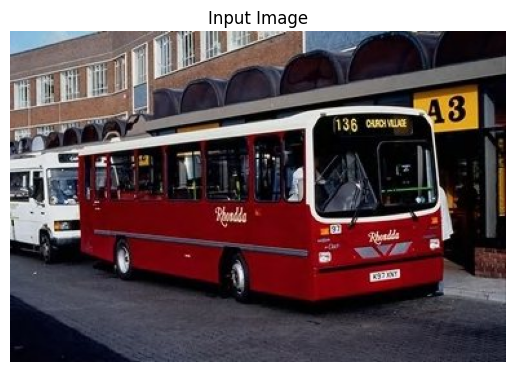

In [ ]:
input_image = Image.open(query_file_paths[0])
plt.imshow(input_image)
plt.axis('off')
plt.title('Input Image')
plt.show()

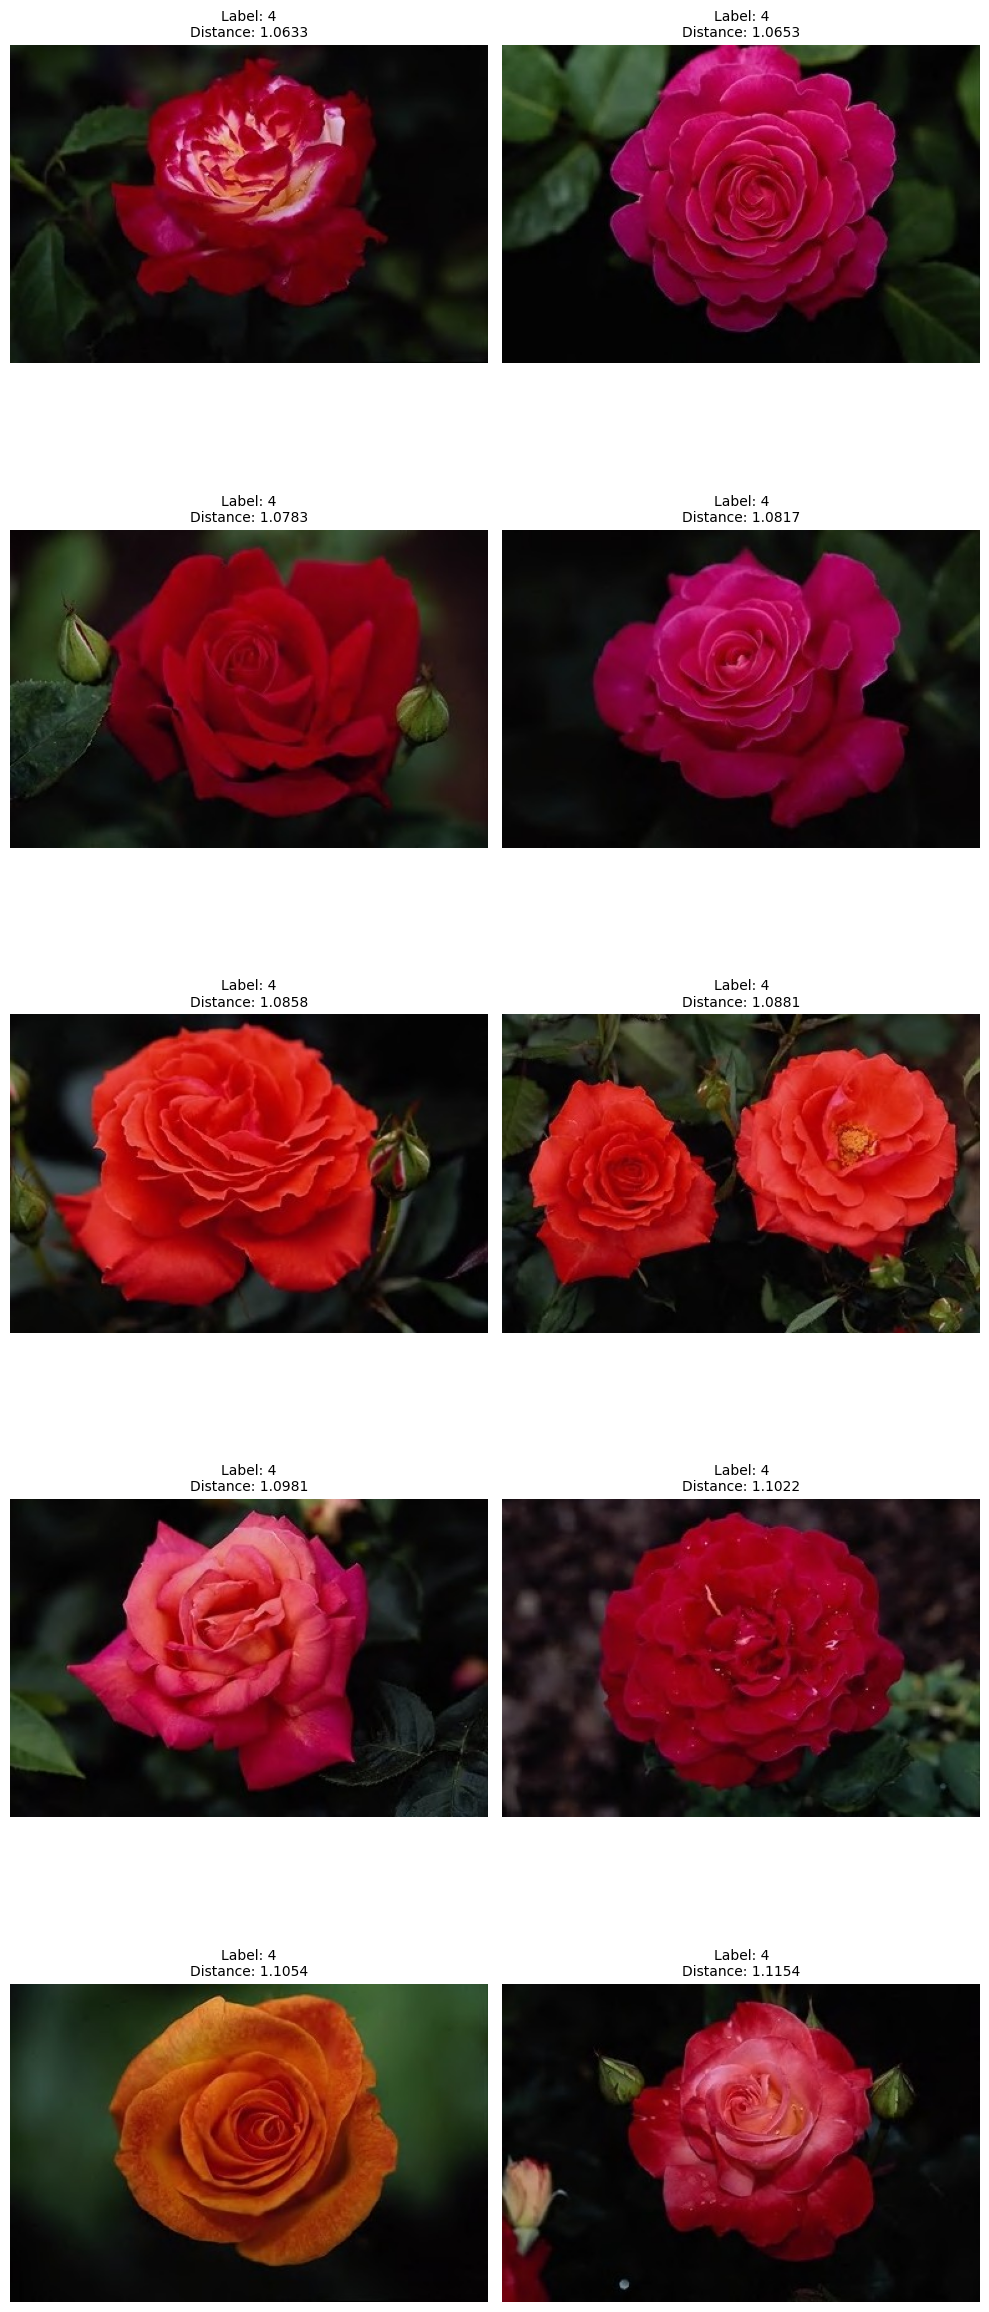

In [ ]:
display_similar_images(similar_images)

**End**